<a href="https://colab.research.google.com/github/CAP4770-group9-project/final-project/blob/notebook%2FfinalNotebook/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classical Portfolio Optimization

This notebook is used to generate a portfolio of 10 random stocks from the AlphaVantage API and then optimize the portfolio weights using Markowitz theory. The optimization analysis can be performed using 3 years of historical stock data (2014-2017). 

The returns of the portfolio with and without optimization over a 3 year test timeframe can then be calculated (2017-2020). These results will be used as the baseline in which the optimization performed through supervised and unsupervised learning will be compared.

In order to perform the optimization, the stock data must be obtained, the **expected returns** must be calculated, the **variance** of the stock data must be calculated and the **effecient frontier** must be found.


## Obtaining stock data



### Getting stock names
The stock names can be found by obtaining an array of all the stocks in the S&P 500 index, generating 10 random numbers and then using those numbers to choose 10 array items.

In [1]:
#Taken from Automating getting the S&P 500 list - Python Programming for Finance p.5
# https://pythonprogramming.net/sp500-company-list-python-programming-for-finance/

import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.strip("\n"))
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

save_sp500_tickers()
    

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA

Next 10 random numbers between 0 and 504 can be generated in order to pick 10 random stock tickers from the list

In [0]:
import random

#tickers = save_sp500_tickers()
#print(len(tickers)) # there are actually 505 stocks in the S&P 500, who knew!

def getRandomTickers(tickers):
  randIndex = []
  randTickers = []
  for i in range(0,10):
    randIndex.append(random.randint(0,504))
  for index in randIndex:
    randTickers.append(tickers[index])
  return randTickers


#print(getRandomTickers(tickers)) 


Now we can get the names of the tickers in the dataset. 

The data was extracted from the API using a NodeJS program which obtained daily price and volume data for each stock over a period of 20 years. Due to the failure to extract data for several stocks, the number of stock tickers is not exactly 505, but rather close to 500.

We first need to import the data from the csv into a pandas dataframe so that it can be further analyzed.

The data is stored in Google Drive and can be accessed via Colab after mounting to Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now the csv can be imported into a dataframe


/content/drive/My Drive/cap4770-project


In [9]:
import pandas as pd
import time

#change directory to where the data is located 
!pwd

#use timer to get process times
start_time = time.time()

#read csv
data = pd.read_csv("SP_DAILY_2000-2020.csv")
#print("read data --- %s seconds ---" % (time.time() - start_time))

#preview first 5 lines
#start_time = time.time()
#print(data.head())
#print("get preview --- %s seconds ---" % (time.time() - start_time))

availableStocks = data['Symbol'].unique()
randomPortfolio = getRandomTickers(availableStocks)

print(randomPortfolio)

/content/drive/My Drive/cap4770-project
['KEYS', 'IRM', 'AJG', 'HSY', 'USB', 'NDAQ', 'UAA', 'CSX', 'DD', 'GD']


In [10]:
stocksData = data[data['Symbol'].isin(availableStocks)]

print(stocksData)

        Symbol        Date    Open   Close     High     Low    Volume
0          MMM  2020-03-26  131.79  135.98  136.355  130.61   5476351
1          MMM  2020-03-25  133.15  131.54  134.690  126.80   7732467
2          MMM  2020-03-24  122.29  132.72  133.450  121.00   9304832
3          MMM  2020-03-23  128.16  117.87  128.400  114.04   7920348
4          MMM  2020-03-20  138.07  124.89  139.240  122.71   9582251
...        ...         ...     ...     ...      ...     ...       ...
2250258    ZTS  2013-02-07   31.00   32.00   32.730   31.00   3800800
2250259    ZTS  2013-02-06   30.98   31.03   31.430   30.75   2126100
2250260    ZTS  2013-02-05   31.25   31.04   31.980   30.85   5013200
2250261    ZTS  2013-02-04   31.09   31.02   31.990   30.76   7695400
2250262    ZTS  2013-02-01   31.50   31.01   31.740   30.47  66789100

[2250263 rows x 7 columns]


In [11]:
stocksData['DateTime'] = pd.to_datetime(stocksData.apply(lambda row: row['Date'], axis=1))

print(stocksData)

        Symbol        Date    Open  ...     Low    Volume   DateTime
0          MMM  2020-03-26  131.79  ...  130.61   5476351 2020-03-26
1          MMM  2020-03-25  133.15  ...  126.80   7732467 2020-03-25
2          MMM  2020-03-24  122.29  ...  121.00   9304832 2020-03-24
3          MMM  2020-03-23  128.16  ...  114.04   7920348 2020-03-23
4          MMM  2020-03-20  138.07  ...  122.71   9582251 2020-03-20
...        ...         ...     ...  ...     ...       ...        ...
2250258    ZTS  2013-02-07   31.00  ...   31.00   3800800 2013-02-07
2250259    ZTS  2013-02-06   30.98  ...   30.75   2126100 2013-02-06
2250260    ZTS  2013-02-05   31.25  ...   30.85   5013200 2013-02-05
2250261    ZTS  2013-02-04   31.09  ...   30.76   7695400 2013-02-04
2250262    ZTS  2013-02-01   31.50  ...   30.47  66789100 2013-02-01

[2250263 rows x 8 columns]


In [12]:
trainData = stocksData[(stocksData['DateTime'] > '2010-01-01') & (stocksData['DateTime'] < '2019-01-01')]

testData = stocksData[(stocksData['DateTime'] > '2019-01-01') & (stocksData['DateTime'] < '2020-01-01')]

print(trainData)

        Symbol        Date    Open   Close    High     Low    Volume   DateTime
311        MMM  2018-12-31  190.34  190.54  191.65  188.50   1804618 2018-12-31
312        MMM  2018-12-28  191.81  189.37  192.30  188.57   2311390 2018-12-28
313        MMM  2018-12-27  183.50  190.70  190.70  182.88   2809032 2018-12-27
314        MMM  2018-12-26  179.38  186.26  186.33  176.87   2925561 2018-12-26
315        MMM  2018-12-24  181.89  178.62  183.54  178.51   2249502 2018-12-24
...        ...         ...     ...     ...     ...     ...       ...        ...
2250258    ZTS  2013-02-07   31.00   32.00   32.73   31.00   3800800 2013-02-07
2250259    ZTS  2013-02-06   30.98   31.03   31.43   30.75   2126100 2013-02-06
2250260    ZTS  2013-02-05   31.25   31.04   31.98   30.85   5013200 2013-02-05
2250261    ZTS  2013-02-04   31.09   31.02   31.99   30.76   7695400 2013-02-04
2250262    ZTS  2013-02-01   31.50   31.01   31.74   30.47  66789100 2013-02-01

[1075723 rows x 8 columns]


In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

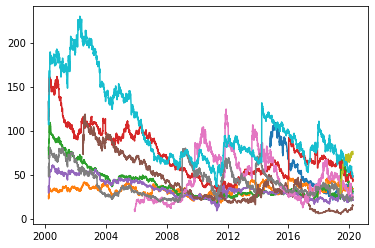

In [14]:
grouped_day_stocks = []
grouped_day = []
plt.figure()
for i in range(0, len(randomPortfolio)):
  grouped_day_stocks.append(stocksData[stocksData['Symbol'] == randomPortfolio[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))
for j in range(0, len(randomPortfolio)):
  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
plt.show()

In [15]:
availableStocks = data['Symbol'].unique()
print(availableStocks)
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

def to_quarter(dt_time):
    if dt_time.month < 3:
      return 1
    if dt_time.month < 6:
      return 2
    if dt_time.month < 9:
      return 3
    return 4

def to_profitable(close, open):
    if (close - open) > 0:
      return 1
    return 0

def to_change_percent(close, open):
    return int(round((close - open)/open, 2) * 100)
    

['MMM' 'ABT' 'ABBV' 'ABMD' 'ACN' 'ATVI' 'ADBE' 'AMD' 'AAP' 'AES' 'AFL' 'A'
 'APD' 'AKAM' 'ALK' 'ALB' 'ARE' 'ALXN' 'ALGN' 'ALLE' 'AGN' 'ADS' 'LNT'
 'ALL' 'GOOGL' 'GOOG' 'MO' 'AMZN' 'AMCR' 'AEE' 'AAL' 'AEP' 'AXP' 'AIG' 'T'
 'AMT' 'AWK' 'AMP' 'ABC' 'AME' 'AMGN' 'APH' 'ADI' 'ANSS' 'ANTM' 'AON'
 'AOS' 'APA' 'AIV' 'AAPL' 'AMAT' 'APTV' 'ADM' 'ARNC' 'ANET' 'AJG' 'AIZ'
 'ATO' 'ADSK' 'ADP' 'AZO' 'AVB' 'AVY' 'BKR' 'BLL' 'BAC' 'BK' 'BAX' 'BDX'
 'BRK.B' 'BBY' 'BIIB' 'BLK' 'BA' 'BKNG' 'BWA' 'BXP' 'BSX' 'BMY' 'AVGO'
 'BR' 'CHRW' 'COG' 'CDNS' 'CPB' 'COF' 'CPRI' 'CAH' 'KMX' 'CCL' 'CAT'
 'CBOE' 'CBRE' 'CDW' 'CE' 'CNC' 'CNP' 'CTL' 'CERN' 'CF' 'SCHW' 'CHTR'
 'CVX' 'CMG' 'CB' 'CHD' 'CI' 'CINF' 'CTAS' 'CSCO' 'C' 'CFG' 'CTXS' 'CLX'
 'CME' 'CMS' 'KO' 'CTSH' 'CL' 'CMCSA' 'CMA' 'CAG' 'CXO' 'COP' 'ED' 'STZ'
 'COO' 'CPRT' 'GLW' 'CTVA' 'COST' 'COTY' 'CCI' 'CSX' 'CMI' 'CVS' 'DHI'
 'DHR' 'DRI' 'DVA' 'DE' 'DAL' 'XRAY' 'DVN' 'FANG' 'DLR' 'DFS' 'DISCA'
 'DISCK' 'DISH' 'DG' 'DLTR' 'D' 'DOV' 'DOW' 'DTE' 'DUK' 'DRE' 'DD' 

In [20]:
trainData = stocksData[(stocksData['DateTime'] > '2012-01-01') & (stocksData['DateTime'] < '2015-01-01')]

testData = stocksData[(stocksData['DateTime'] > '2015-01-01') & (stocksData['DateTime'] < '2016-01-01')]

trainData['Symbol'] = trainData.apply(lambda row: availableStocks.tolist().index(row['Symbol']), axis=1)
testData['Symbol'] = testData.apply(lambda row: availableStocks.tolist().index(row['Symbol']), axis=1)

trainData['Quarter'] = trainData.apply(lambda row: to_quarter(row['DateTime']), axis=1)
testData['Quarter'] = testData.apply(lambda row: to_quarter(row['DateTime']), axis=1)

#trainData['Profitable'] = trainData.apply(lambda row: to_profitable(row['Close'], row['Open']), axis=1)
#testData['Profitable'] = testData.apply(lambda row: to_profitable(row['Close'], row['Open']), axis=1)

#trainData['DateTime'] = trainData.apply(lambda row: to_integer(row['DateTime']), axis=1)
#testData['DateTime'] = testData.apply(lambda row: to_integer(row['DateTime']), axis=1)

trainData['PercentChange'] = trainData.apply(lambda row: to_change_percent(row['Close'], row['Open']), axis=1)
testData['PercentChange'] = testData.apply(lambda row: to_change_percent(row['Close'], row['Open']), axis=1)



#df_train = pd.DataFrame(trainData, columns = ['Symbol', 'Open', 'Close', 'High', 'Low', 'Volume', 'DateTime', 'Profitable'])
#df_test = pd.DataFrame(testData, columns = ['Symbol', 'Open', 'Close', 'High', 'Low', 'Volume', 'DateTime', 'Profitable'])

df_train = pd.DataFrame(trainData, columns = ['Symbol', 'Open', 'Volume', 'Quarter', 'PercentChange'])
df_test = pd.DataFrame(testData, columns = ['Symbol', 'Open', 'Volume', 'Quarter', 'PercentChange'])

#df_train.drop(['Date'], axis=1)
#df_test.drop(['Date'], axis=1)

print(df_train)
print(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

         Symbol    Open    Volume  Quarter  PercentChange
1317          0  166.00   1631764        4             -1
1318          0  166.55   1180680        4              0
1319          0  166.30   1218833        4              0
1320          0  167.34   1607376        4             -1
1321          0  166.17    981961        4              0
...         ...     ...       ...      ...            ...
2250258     502   31.00   3800800        1              3
2250259     502   30.98   2126100        1              0
2250260     502   31.25   5013200        1             -1
2250261     502   31.09   7695400        1              0
2250262     502   31.50  66789100        1             -2

[354535 rows x 5 columns]
         Symbol    Open   Volume  Quarter  PercentChange
1065          0  151.73  1607102        4             -1
1066          0  152.79  1553075        4             -1
1067          0  152.20  1824690        4              0
1068          0  151.13  1275184        4        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
print(df_test.shape)
print(df_train.shape)
print(df_train['PercentChange'].values)

#from sklearn.naive_bayes import MultinomialNB
#modelNB = MultinomialNB().fit(df_train.drop(['PercentChange'], axis=1), df_train['PercentChange'])

#from sklearn.tree import DecisionTreeClassifier
#modelDT = DecisionTreeClassifier().fit(df_train.drop(['PercentChange'], axis=1), df_train['PercentChange'])

from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(n_estimators=500, max_depth=5).fit(df_train.drop(['PercentChange'], axis=1), df_train['PercentChange'])

(122143, 5)
(354535, 5)
[-1  0  0 ... -1  0 -2]


In [0]:
from sklearn.metrics import confusion_matrix

#score1 = modelNB.score(df_test.drop(['PercentChange'], axis=1), df_test['PercentChange'])
#pred1 = modelNB.predict(df_test.drop(['PercentChange'], axis=1))
#cm1 = confusion_matrix(df_test['PercentChange'], pred1, modelNB.classes_)
#print(score1)
#print(cm1)

#score2 = modelDT.score(df_test.drop(['PercentChange'], axis=1), df_test['PercentChange'])
#pred2 = modelDT.predict(df_test.drop(['PercentChange'], axis=1))
#cm2 = confusion_matrix(df_test['PercentChange'], pred2, modelDT.classes_)
#print(score2)
#print(cm2)

score3 = modelRF.score(df_test.drop(['PercentChange'], axis=1), df_test['PercentChange'])
pred3 = modelRF.predict(df_test.drop(['PercentChange'], axis=1))
cm3 = confusion_matrix(df_test['PercentChange'], pred3, modelRF.classes_)
print(score3)
print(cm3)

#model.predict(df_test)

In [0]:
print(pred3)

df_test_show = testData
df_test_show['Prediction'] = pred3

print(df_test_show)

grouped_day_stocks = []
grouped_day = []
plt.figure()
#len(availableStocks)
for i in range(0, 1):
  grouped_day_stocks.append(df_test_show[df_test_show['Symbol'] == availableStocks[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))
print(grouped_day);
for j in range(0, 1):
  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['PercentChange'], grouped_day[j].size().index, grouped_day_stocks[j]['Prediction'])
plt.show()